### 回测思路：sum(近远月仓位权重*对应月份合约收益率)，空头权重为负多头权重为正，(收益率+1).cumprod

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [63]:
def max_drawdown(date_series, capital_series):
    """
    计算最大回撤
    :param date_series: 日期序列
    :param capital_series: 收益序列
    :return:输出最大回撤及开始日期和结束日期
    """
    df = pd.DataFrame({'date': date_series, 'capital': capital_series})
    df.sort_values(by='date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['max2here'] = pd.Series.expanding(df['capital']).max()
    df['dd2here'] = df['capital'] / df['max2here'] - 1 
    temp = df.sort_values(by='dd2here').iloc[0][['date', 'dd2here']]
    max_dd = temp['dd2here']
    end_date = temp['date']

    df = df[df['date'] <= end_date]
    start_date = df.sort_values(by='capital', ascending=False).iloc[0]['date']
    return max_dd, start_date, end_date


def annual_return(date_series, capital_series, num_work):
    """
    计算年化收益率
    :param date_series: 日期序列
    :param capital_series:资产序列
    :return: 输出在回测期间的年化收益率
    """
    df = pd.DataFrame({'date': date_series, 'capital': capital_series})
    df.sort_values(by='date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    annual = pow(df.loc[len(df.index) - 1, 'capital'] / df.loc[0, 'capital'], num_work / len(capital_series)) - 1
    return annual

In [17]:
df = pd.read_excel('output.xlsx', index_col=0)
select_col = df.columns.tolist()[:-9]
df[select_col] = df[select_col].apply(lambda x: x.pct_change().fillna(0))
select_col = select_col[:-2]

df['Total_Pos'] = abs(df['LONG_2'] - df['SHORT_2']) + df['LONG_3'] +  df['SHORT_1'] 
df['POS_1'] = -df['SHORT_1'] / df['Total_Pos']
df['POS_2'] = (df['LONG_2'] - df['SHORT_2']) / df['Total_Pos']
df['POS_3'] = df['LONG_3'] / df['Total_Pos']

months = list(np.unique([m[:-3] for m in df.index.astype(str).tolist()]))

out_df = pd.DataFrame()
for m in tqdm(months[:-1]):
    sub_df = df[m]
    weight = sub_df.iloc[:, -3:]
    if m < '2020-01':
        if int(m[2:4]) < 9:
            col = [x for x in select_col if m[2:4] in x] + [x for x in select_col if ('0'+str(int(m[2:4])+1)) in x][:3]
        if int(m[2:4]) < 19:
            col = [x for x in select_col if m[2:4] in x] + [x for x in select_col if str(int(m[2:4])+1) in x][:3]
        if int(m[2:4]) == 19:
            col = [x for x in select_col if m[2:4] in x] + select_col[-12:-9]
    else:
        col = select_col[-12:]
        
    sub = sub_df[col]
    start_col = int(m[-2:])
    end_col = int(m[-2:]) + 3

    sub_df['Hedge'] = (sub.iloc[:, start_col:end_col].values * weight.values).sum(axis=1)
    weight['POS_1'] = weight['POS_1'].apply(lambda x: 0 if x>0 else x)
    weight['POS_2'] = weight['POS_2'].apply(lambda x: 0 if x>0 else x)
    sub_df['Short_Return'] = (sub.iloc[:, start_col:(end_col-1)].values * weight[['POS_1', 'POS_2']].values).sum(axis=1)
    sub_df['Long_Return'] = sub_df['Hedge'] - sub_df['Short_Return']
    out_df = out_df.append(sub_df)
# out_df.to_excel('hedge.xlsx')

out_df[['VIX', 'SPX500', 'Hedge','Short_Return', 'Long_Return']] = out_df[['VIX', 'SPX500', 'Hedge','Short_Return', 'Long_Return']].apply(lambda x: (x+1).cumprod())

In [66]:
print('Max Drawdown: ', max_drawdown(out_df.index.tolist(), out_df['Hedge']))
print('Annual Return: ', annual_return(out_df.index.tolist(), out_df['Hedge'], 250))

Max Drawdown:  (-0.5115366896857586, Timestamp('2014-01-21 00:00:00'), Timestamp('2018-04-24 00:00:00'))
Annual Return:  0.12352360082908076


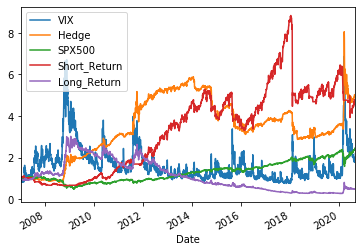

In [61]:
out_df[['VIX', 'Hedge', 'SPX500','Short_Return', 'Long_Return']].plot()